In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [101]:
N_ep = 10 # Number of episodes
prop_test = 0.2 # Proportion of test set
shuffle = True # Shuffle data every episode
episode_rec = int(N_ep/10)

In [102]:
# Load data
f = open('replay_memory_0_new','rb')
# f = open('replay_memory_0_1000','rb')
dataset = pickle.load(f)

# Data size
num_data = len(dataset)
# Features
X = torch.cat([x[0] for x in dataset]).float()
# Labels
y = torch.from_numpy(np.array([x[1] for x in dataset])).float()

input_dim = X.size(1)

# Initial shuffle
if shuffle:
    permutation = torch.randperm(num_data)
    X = X[permutation]
    y = y[permutation]

num_train = int(num_data*(1-prop_test))

X_train = X[:num_train]
y_train = y[:num_train]
X_test = X[num_train:]
y_test = y[num_train:]

# Normalize
y_train = y_train/abs(y_train).max()
y_test = y_test/abs(y_test).max()

In [103]:
# Network
class net(nn.Module):
    def __init__(self, input_dim=6, output_dim=1, hidden_size=6, hidden_dropout_prob=0):
        super(net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size) # input layer -> hidden layer
        self.fc2 = nn.Linear(hidden_size, output_dim) # hidden layer -> output layer
        
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = net(input_dim=input_dim)

In [104]:
sample_num=101
print(model(X[sample_num]))
print(y[sample_num])
print(model(X[sample_num])-y[sample_num])

tensor([-0.6324])
tensor(1.00000e-02 *
       -8.7905)
tensor([-0.5445])


In [105]:

optimizer = optim.SGD(model.parameters(),lr=0.001)

training_loss = []
test_loss = []
# Training
for i_ep in range(N_ep):
    
    if shuffle:
        permutation = torch.randperm(num_train)
        X_train = X_train[permutation]
        y_train = y_train[permutation]
        
    for i_data in range(num_train):
        features = X_train[i_data]
        y_data = y_train[i_data]
        #features = X
        #y_data = y.view(-1,1)
        
        y_pred = model(features)
        
        #loss = F.smooth_l1_loss(y_pred,y_data)
        loss = torch.mean((y_pred - y_data)**2)
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Compute training & test losses and record
    y_train_pred = model(X_train)
    loss_train = torch.mean((y_train-y_train_pred)**2)
    y_test_pred = model(X_test)
    loss_test = torch.mean((y_test-y_test_pred)**2)
    training_loss.append(loss_train)
    test_loss.append(loss_test)
        
    if i_ep != 0 and (i_ep % episode_rec == 0):
        print(i_ep)

1
2
3
4
5
6
7
8
9


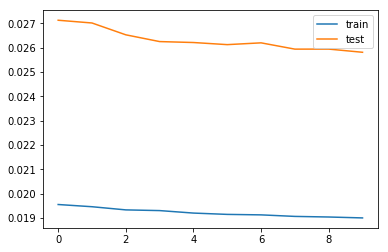

In [106]:
plt.plot(training_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
#plt.savefig('train_loss_curve.png')
plt.show()

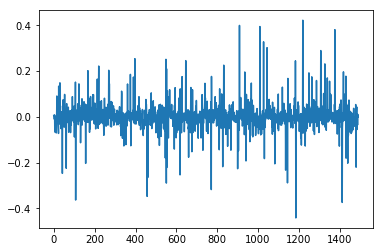

tensor(2.6759)


In [107]:
plt.plot(y)
plt.show()
print (sum(y))

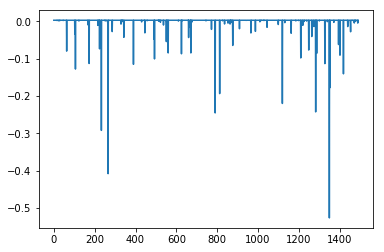

In [108]:
plt.plot(model(X).detach().numpy())
plt.show()